# Autoencoders

Autoencoders are artificial neural networks capable of learning efficient representations of the input data,
called codings, without any supervision (i.e., the training set is unlabeled). 

They can be used for dimensionality reduction,
feature extraction, unsupervised pretraining, or as generative models

In [1]:
%matplotlib inline
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import sklearn

2024-10-31 07:42:44.960288: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
np.random.seed(42)
tf.random.set_seed(42)

Utility functions

In [18]:
def plot_image(image):
    plt.imshow(image, cmap="binary")
    plt.axis("off")

PCA with a simple linear Autoencoder

3D dataset

In [3]:
np.random.seed(4)

def generate_3d_data(m, w1=0.1, w2=0.3, noise=0.1):
    angles = np.random.rand(m) * 3 * np.pi / 2 - 0.5
    data = np.empty((m, 3))
    data[:, 0] = np.cos(angles) + np.sin(angles)/2 + noise * np.random.randn(m) / 2
    data[:, 1] = np.sin(angles) * 0.7 + noise * np.random.randn(m) / 2
    data[:, 2] = data[:, 0] * w1 + data[:, 1] * w2 + noise * np.random.randn(m)
    return data

X_train = generate_3d_data(60)
X_train = X_train - X_train.mean(axis=0, keepdims=0)

In [4]:
encoder = keras.models.Sequential([keras.layers.Dense(2, input_shape=[3])])
decoder = keras.models.Sequential([keras.layers.Dense(3, input_shape=[2])])
autoencoder = keras.models.Sequential([encoder, decoder])

autoencoder.compile(loss="mse", optimizer=keras.optimizers.SGD(learning_rate=1.5))

2024-10-31 07:42:57.759656: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-10-31 07:42:57.759733: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [5]:
history = autoencoder.fit(X_train, X_train, epochs=20)

Epoch 1/20


2024-10-31 07:43:00.956298: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-10-31 07:43:00.985945: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignVariableOp.


2/2 [==============================] - 0s 68ms/step - loss: 0.3991
Epoch 2/20
2/2 [==============================] - 0s 9ms/step - loss: 0.2600
Epoch 3/20
2/2 [==============================] - 0s 9ms/step - loss: 0.5315
Epoch 4/20
2/2 [==============================] - 0s 10ms/step - loss: 0.6720
Epoch 5/20
2/2 [==============================] - 0s 9ms/step - loss: 0.4605
Epoch 6/20
2/2 [==============================] - 0s 10ms/step - loss: 0.1256
Epoch 7/20
2/2 [==============================] - 0s 9ms/step - loss: 0.1675
Epoch 8/20
2/2 [==============================] - 0s 8ms/step - loss: 0.1411
Epoch 9/20
2/2 [==============================] - 0s 9ms/step - loss: 0.0727
Epoch 10/20
2/2 [==============================] - 0s 9ms/step - loss: 0.0342
Epoch 11/20
2/2 [==============================] - 0s 9ms/step - loss: 0.0269
Epoch 12/20
2/2 [==============================] - 0s 8ms/step - loss: 0.0214
Epoch 13/20
2/2 [==============================] - 0s 9ms/step - loss: 0.0137
Epo

In [6]:
codings = encoder.predict(X_train)

2/2 [==============================] - 0s 9ms/step


2024-10-31 07:43:06.611486: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


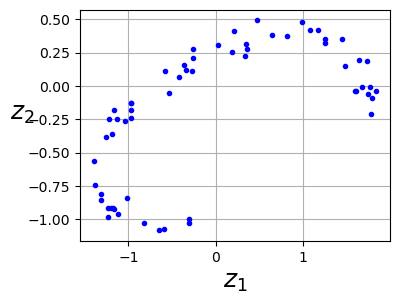

In [7]:
fig = plt.figure(figsize=(4,3))
plt.plot(codings[:,0], codings[:, 1], "b.")
plt.xlabel("$z_1$", fontsize=18)
plt.ylabel("$z_2$", fontsize=18, rotation=0)
plt.grid(True)
plt.show()

## Stacked Autoencoders

In [8]:
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()
X_train_full = X_train_full.astype(np.float32) / 255
X_test = X_test.astype(np.float32) / 255
X_train, X_valid = X_train_full[:-5000], X_train_full[-5000:]
y_train, y_valid = y_train_full[:-5000], y_train_full[-5000:]

Training

In [9]:
def rounded_accuracy(y_true, y_pred):
    return keras.metrics.binary_accuracy(tf.round(y_true), tf.round(y_pred))

In [10]:
stacked_encoder = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(100, activation="selu"),
    keras.layers.Dense(30, activation="selu"),
])
stacked_decoder = keras.models.Sequential([
    keras.layers.Dense(100, activation="selu", input_shape=[30]),
    keras.layers.Dense(28 * 28, activation="sigmoid"),
    keras.layers.Reshape([28, 28])
])
stacked_ae = keras.models.Sequential([stacked_encoder, stacked_decoder])
stacked_ae.compile(loss="binary_crossentropy",
                   optimizer=keras.optimizers.SGD(learning_rate=1.5), metrics=[rounded_accuracy])
history = stacked_ae.fit(X_train, X_train, epochs=20,
                         validation_data=(X_valid, X_valid))

Epoch 1/20


2024-10-31 07:43:59.294907: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-10-31 07:43:59.342210: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignVariableOp.


1719/1719 [==============================] - ETA: 0s - loss: 0.3372 - rounded_accuracy: 0.8877

2024-10-31 07:44:30.991086: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1719/1719 [==============================] - 34s 19ms/step - loss: 0.3372 - rounded_accuracy: 0.8877 - val_loss: 0.3153 - val_rounded_accuracy: 0.9046
Epoch 2/20
1719/1719 [==============================] - 32s 19ms/step - loss: 0.3052 - rounded_accuracy: 0.9154 - val_loss: 0.3027 - val_rounded_accuracy: 0.9196
Epoch 3/20
1719/1719 [==============================] - 31s 18ms/step - loss: 0.2979 - rounded_accuracy: 0.9221 - val_loss: 0.3014 - val_rounded_accuracy: 0.9134
Epoch 4/20
1719/1719 [==============================] - 31s 18ms/step - loss: 0.2940 - rounded_accuracy: 0.9256 - val_loss: 0.2941 - val_rounded_accuracy: 0.9284
Epoch 5/20
1719/1719 [==============================] - 32s 18ms/step - loss: 0.2916 - rounded_accuracy: 0.9276 - val_loss: 0.2917 - val_rounded_accuracy: 0.9287
Epoch 6/20
1719/1719 [==============================] - 32s 18ms/step - loss: 0.2899 - rounded_accuracy: 0.9291 - val_loss: 0.2906 - val_rounded_accuracy: 0.9309
Epoch 7/20
1719/1719 [=================

In [19]:
def show_reconstructions(model, images=X_valid, n_images=5):
    reconstructions = model.predict(images[:n_images])
    fig = plt.figure(figsize=(n_images * 1.5, 3))
    for image_index in range(n_images):
        plt.subplot(2, n_images, 1 + image_index)
        plot_image(images[image_index])
        plt.subplot(2, n_images, 1 + n_images + image_index)
        plot_image(reconstructions[image_index])

1/1 [==============================] - 0s 26ms/step


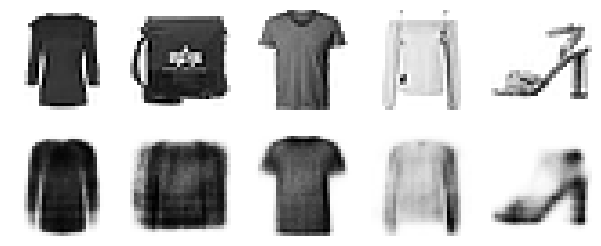

In [20]:
show_reconstructions(stacked_ae)

## Visualizing Fashion MNIST

In [21]:
np.random.seed(42)

from sklearn.manifold import TSNE

X_valid_compressed = stacked_encoder.predict(X_valid)
tsne = TSNE()
X_valid_2D = tsne.fit_transform(X_valid_compressed)
X_valid_2D = (X_valid_2D - X_valid_2D.min()) / (X_valid_2D.max() - X_valid_2D.min())

 52/157 [========>.....................] - ETA: 0s

2024-10-31 08:04:58.661703: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


157/157 [==============================] - 1s 3ms/step
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


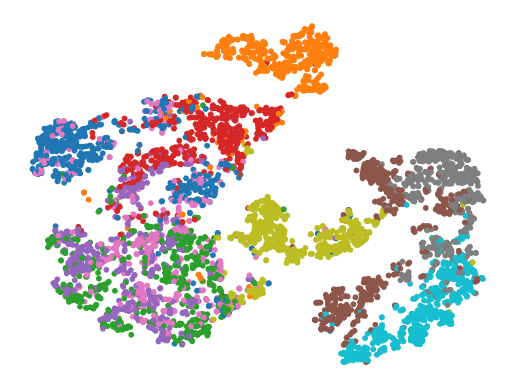

In [22]:
plt.scatter(X_valid_2D[:, 0], X_valid_2D[:, 1], c=y_valid, s=10, cmap="tab10")
plt.axis("off")
plt.show()

Better diagram

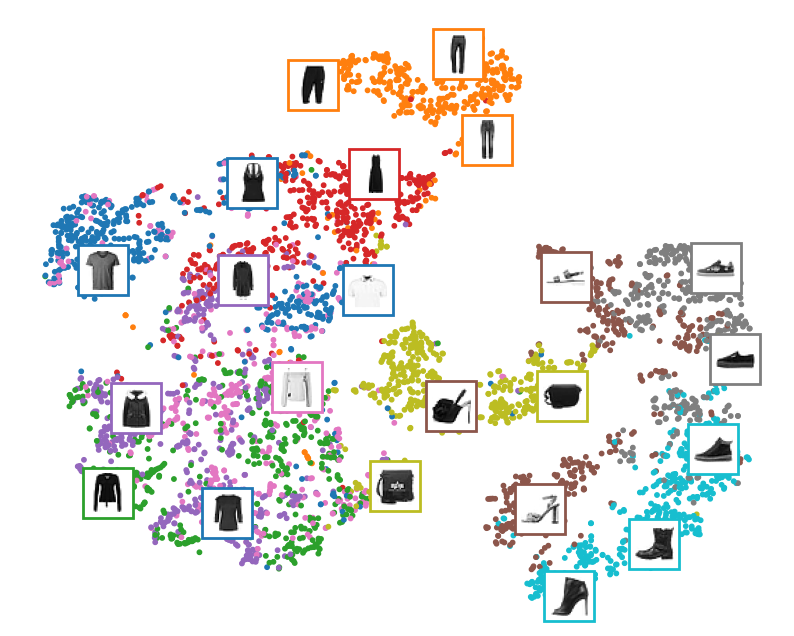

In [23]:
# adapted from https://scikit-learn.org/stable/auto_examples/manifold/plot_lle_digits.html
plt.figure(figsize=(10, 8))
cmap = plt.cm.tab10
plt.scatter(X_valid_2D[:, 0], X_valid_2D[:, 1], c=y_valid, s=10, cmap=cmap)
image_positions = np.array([[1., 1.]])
for index, position in enumerate(X_valid_2D):
    dist = np.sum((position - image_positions) ** 2, axis=1)
    if np.min(dist) > 0.02: # if far enough from other images
        image_positions = np.r_[image_positions, [position]]
        imagebox = mpl.offsetbox.AnnotationBbox(
            mpl.offsetbox.OffsetImage(X_valid[index], cmap="binary"),
            position, bboxprops={"edgecolor": cmap(y_valid[index]), "lw": 2})
        plt.gca().add_artist(imagebox)
plt.axis("off")
plt.show()

Tying weights

In [24]:
class DenseTranspose(keras.layers.Layer):
    def __init__(self, dense, activation=None, **kwargs):
        self.dense = dense
        self.activation = keras.activations.get(activation)
        super().__init__(**kwargs)
    def build(self, batch_input_shape):
        self.biases = self.add_weight(name="bias",
                                      shape=[self.dense.input_shape[-1]],
                                      initializer="zeros")
        super().build(batch_input_shape)
    def call(self, inputs):
        z = tf.matmul(inputs, self.dense.weights[0], transpose_b=True)
        return self.activation(z + self.biases)

In [25]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

dense_1 = keras.layers.Dense(100, activation="selu")
dense_2 = keras.layers.Dense(30, activation="selu")

tied_encoder = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    dense_1,
    dense_2
])

tied_decoder = keras.models.Sequential([
    DenseTranspose(dense_2, activation="selu"),
    DenseTranspose(dense_1, activation="sigmoid"),
    keras.layers.Reshape([28, 28])
])

tied_ae = keras.models.Sequential([tied_encoder, tied_decoder])

tied_ae.compile(loss="binary_crossentropy",
                optimizer=keras.optimizers.SGD(learning_rate=1.5), metrics=[rounded_accuracy])
history = tied_ae.fit(X_train, X_train, epochs=10,
                      validation_data=(X_valid, X_valid))

Epoch 1/10


2024-10-31 08:07:08.068064: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-10-31 08:07:08.115711: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignVariableOp.


1719/1719 [==============================] - ETA: 0s - loss: 0.3268 - rounded_accuracy: 0.8959

2024-10-31 08:07:38.761321: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1719/1719 [==============================] - 33s 19ms/step - loss: 0.3268 - rounded_accuracy: 0.8959 - val_loss: 0.3072 - val_rounded_accuracy: 0.9092
Epoch 2/10
1719/1719 [==============================] - 31s 18ms/step - loss: 0.2981 - rounded_accuracy: 0.9217 - val_loss: 0.2952 - val_rounded_accuracy: 0.9276
Epoch 3/10
1719/1719 [==============================] - 32s 19ms/step - loss: 0.2922 - rounded_accuracy: 0.9273 - val_loss: 0.2965 - val_rounded_accuracy: 0.9173
Epoch 4/10
1719/1719 [==============================] - 31s 18ms/step - loss: 0.2891 - rounded_accuracy: 0.9301 - val_loss: 0.2901 - val_rounded_accuracy: 0.9329
Epoch 5/10
1719/1719 [==============================] - 32s 18ms/step - loss: 0.2870 - rounded_accuracy: 0.9320 - val_loss: 0.2870 - val_rounded_accuracy: 0.9324
Epoch 6/10
1719/1719 [==============================] - 32s 18ms/step - loss: 0.2855 - rounded_accuracy: 0.9334 - val_loss: 0.2860 - val_rounded_accuracy: 0.9357
Epoch 7/10
1719/1719 [=================

1/1 [==============================] - 0s 186ms/step


2024-10-31 08:12:54.141068: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


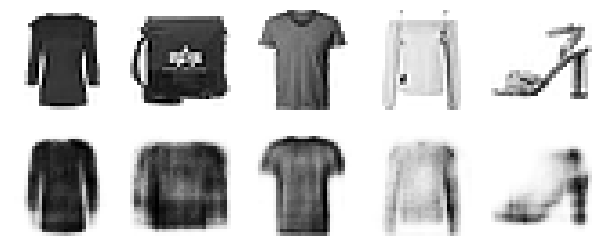

In [26]:
show_reconstructions(tied_ae)
plt.show()

Training single autoencoder at

In [27]:
def train_autoencoder(n_neurons, X_train, X_valid, loss, optimizer,
                      n_epochs=10, output_activation=None, metrics=None):
    n_inputs = X_train.shape[-1]
    encoder = keras.models.Sequential([
        keras.layers.Dense(n_neurons, activation="selu", input_shape=[n_inputs])
    ])
    decoder = keras.models.Sequential([
        keras.layers.Dense(n_inputs, activation=output_activation),
    ])
    autoencoder = keras.models.Sequential([encoder, decoder])
    autoencoder.compile(optimizer, loss, metrics=metrics)
    autoencoder.fit(X_train, X_train, epochs=n_epochs,
                    validation_data=(X_valid, X_valid))
    return encoder, decoder, encoder(X_train), encoder(X_valid)

In [28]:
K = keras.backend
X_train_flat = K.batch_flatten(X_train) # equivalent to .reshape(-1, 28 * 28)
X_valid_flat = K.batch_flatten(X_valid)
enc1, dec1, X_train_enc1, X_valid_enc1 = train_autoencoder(
    100, X_train_flat, X_valid_flat, "binary_crossentropy",
    keras.optimizers.SGD(learning_rate=1.5), output_activation="sigmoid",
    metrics=[rounded_accuracy])
enc2, dec2, _, _ = train_autoencoder(
    30, X_train_enc1, X_valid_enc1, "mse", keras.optimizers.SGD(learning_rate=0.05),
    output_activation="selu")

Epoch 1/10


2024-10-31 08:13:57.598951: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-10-31 08:13:57.633263: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignVariableOp.


1719/1719 [==============================] - ETA: 0s - loss: 0.3450 - rounded_accuracy: 0.8869

2024-10-31 08:14:19.723049: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1719/1719 [==============================] - 24s 13ms/step - loss: 0.3450 - rounded_accuracy: 0.8869 - val_loss: 0.3116 - val_rounded_accuracy: 0.9154
Epoch 2/10
1719/1719 [==============================] - 23s 13ms/step - loss: 0.3029 - rounded_accuracy: 0.9213 - val_loss: 0.2996 - val_rounded_accuracy: 0.9257
Epoch 3/10
1719/1719 [==============================] - 23s 13ms/step - loss: 0.2942 - rounded_accuracy: 0.9293 - val_loss: 0.2929 - val_rounded_accuracy: 0.9319
Epoch 4/10
1719/1719 [==============================] - 23s 13ms/step - loss: 0.2887 - rounded_accuracy: 0.9345 - val_loss: 0.2885 - val_rounded_accuracy: 0.9366
Epoch 5/10
1719/1719 [==============================] - 22s 13ms/step - loss: 0.2851 - rounded_accuracy: 0.9380 - val_loss: 0.2854 - val_rounded_accuracy: 0.9396
Epoch 6/10
1719/1719 [==============================] - 22s 13ms/step - loss: 0.2824 - rounded_accuracy: 0.9406 - val_loss: 0.2831 - val_rounded_accuracy: 0.9411
Epoch 7/10
1719/1719 [=================

2024-10-31 08:17:41.138343: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-10-31 08:17:41.163592: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignVariableOp.


1719/1719 [==============================] - ETA: 0s - loss: 0.6228

2024-10-31 08:17:57.883806: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1719/1719 [==============================] - 18s 10ms/step - loss: 0.6228 - val_loss: 0.3421
Epoch 2/10
1719/1719 [==============================] - 17s 10ms/step - loss: 0.2835 - val_loss: 0.2433
Epoch 3/10
1719/1719 [==============================] - 17s 10ms/step - loss: 0.2241 - val_loss: 0.2050
Epoch 4/10
1719/1719 [==============================] - 18s 10ms/step - loss: 0.1958 - val_loss: 0.1894
Epoch 5/10
1719/1719 [==============================] - 17s 10ms/step - loss: 0.1861 - val_loss: 0.1805
Epoch 6/10
1719/1719 [==============================] - 17s 10ms/step - loss: 0.1802 - val_loss: 0.1769
Epoch 7/10
1719/1719 [==============================] - 17s 10ms/step - loss: 0.1743 - val_loss: 0.1775
Epoch 8/10
1719/1719 [==============================] - 17s 10ms/step - loss: 0.1704 - val_loss: 0.1774
Epoch 9/10
1719/1719 [==============================] - 17s 10ms/step - loss: 0.1691 - val_loss: 0.1671
Epoch 10/10
1719/1719 [==============================] - 17s 10ms/step - lo

In [29]:
stacked_ae_1_by_1 = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    enc1, enc2, dec2, dec1,
    keras.layers.Reshape([28, 28])
])

1/1 [==============================] - 0s 65ms/step


2024-10-31 08:22:30.640525: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


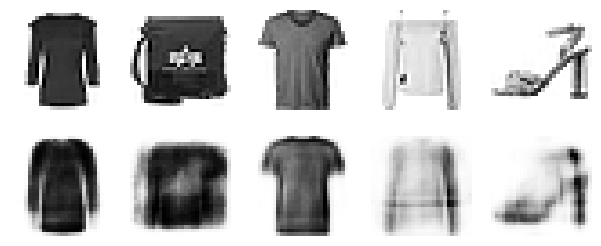

In [30]:
show_reconstructions(stacked_ae_1_by_1)
plt.show()